In [7]:
import numpy as np
import matplotlib.pyplot as plt
from numba import jit, jitclass, boolean, int64, float64, uint8, char, types

@jit(nopython=True)
def bernouilli_kl(p, q, tol = 1e-8):
    if abs(p) < tol or abs(1 - p) < tol:
        return 0
    elif abs(p - q) < tol:
        return 0
    elif abs(q) < tol or abs(1 - q) < tol:
        return np.inf
    else :
        return p*np.log(p/q) + (1-p)*np.log((1-p)/(1-q))


@jit(nopython=True)
def draw_reward(arm_t, mu, R, t):
    r_t = np.random.binomial(1, mu[arm_t])
    return r_t

@jit(nopython=True)
def objective(mu, mu_hat, N, t):
    return bernouilli_kl(mu_hat, mu, tol = 1e-8) - np.log(1 + t*np.log(t)**2)/N

@jit(nopython=True)
def bisection(mu_right, mu_left, N, t, mu_hat, tol = 1e-5):
    while abs(mu_right - mu_left) > tol:
        mu_mean = (mu_right + mu_left)/2
        if objective(mu_mean, mu_hat, N, t) > 0:
            mu_right = mu_mean
        else :
            mu_left = mu_mean
    return mu_mean

@jit(nopython=True)
def choose_arm(method, k, mu_hat, t, N):
    if method == 'KL':
        mu = np.zeros(mu_hat.shape)
        for arm in range(k):
            mu[arm] = bisection(mu_right = 1 - 1e-5, mu_left = mu_hat[arm] + 1e-5, N = N[arm], t = t, mu_hat = mu_hat[arm], tol = 1e-5)
        if (mu == mu.sum() / len(mu)).all():
            return np.random.randint(2)
        else :
            return np.argmax(mu)
    elif method == 'Regular':
        return np.argmax(mu_hat + np.sqrt(np.log(1 + t*np.log(t)**2)/(2 * N)))

@jit(nopython=True)
def run(method, n, k, mu):
    N = np.ones(k)
    R = np.zeros(k)
    regret = 0
    mu_hat = np.zeros(k)
    best_mu =  np.max(mu)
    for t in range(1, n + 1):
        arm_t = int(choose_arm(method, k, mu_hat, t, N))
        r_t = draw_reward(arm_t, mu, R, t)
        R[arm_t] += r_t
        N[arm_t] += 1
        regret += best_mu - mu[arm_t] 
        mu_hat = R / N
    return N, R, mu_hat, regret


@jit(nopython=True)
def run_total(method, n, k, step_delta, n_runs):
    delta_array = np.arange(-0.45, 0.46, step_delta)
    regrets = np.zeros((n_runs, len(delta_array)), dtype=np.float64)
    for trial in range(n_runs):
        for idx in range(len(delta_array)):
            N, R, mu_hat, regret = run(method, n=n, k=k, mu = np.array([0.5, 0.5 + delta_array[idx]]))
            regrets[trial, idx] = regret
    return regrets


@jit(nopython=True)
def run_total_2(method, n, k, step_delta, n_runs):
    delta_array = np.arange(-0.09, 0.89, step_delta)
    regrets = np.zeros((n_runs, len(delta_array)), dtype=np.float64)
    for trial in range(n_runs):
        for idx in range(len(delta_array)):
            N, R, mu_hat, regret = run(method, n=n, k=k, mu = np.array([0.1, 0.1 + delta_array[idx]]))
            regrets[trial, idx] = regret
    return regrets


@jit(nopython=True)
def run_total_3(method, n, k, step_delta, n_runs):
    delta_array = np.arange(-0.89, 0.09, step_delta)
    regrets = np.zeros((n_runs, len(delta_array)), dtype=np.float64)
    for trial in range(n_runs):
        for idx in range(len(delta_array)):
            N, R, mu_hat, regret = run(method, n=n, k=k, mu = np.array([0.9, 0.9 + delta_array[idx]]))
            regrets[trial, idx] = regret
    return regrets



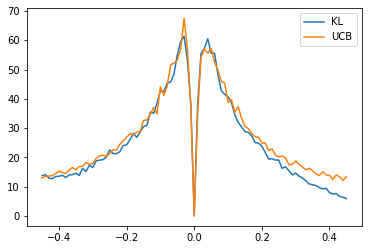

In [4]:
regrets_kl = run_total('KL', n=int(1e4), k=2, step_delta = 0.01, n_runs=100)
regrets_reg = run_total('Regular', n=int(1e4), k=2, step_delta = 0.01, n_runs=100)

delta_array = np.arange(-0.45, 0.46, 0.01)
plt.plot(delta_array, regrets_kl.mean(axis = 0)[:len(delta_array)], label = 'KL')
plt.plot(delta_array,regrets_reg.mean(axis = 0)[:len(delta_array)], label = 'UCB')
plt.legend()

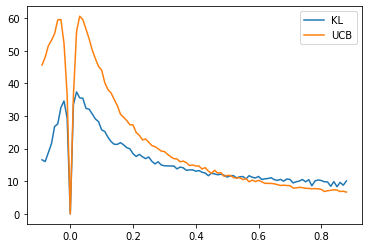

In [9]:
regrets_kl = run_total_2('KL', n=int(1e4), k=2, step_delta = 0.01, n_runs=100)
regrets_reg = run_total_2('Regular', n=int(1e4), k=2, step_delta = 0.01, n_runs=100)

delta_array = np.arange(-0.09, 0.89, 0.01)
plt.plot(delta_array, regrets_kl.mean(axis = 0)[:len(delta_array)], label = 'KL')
plt.plot(delta_array,regrets_reg.mean(axis = 0)[:len(delta_array)], label = 'UCB')
plt.legend()

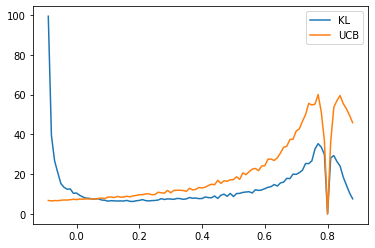

In [10]:
regrets_kl = run_total_3('KL', n=int(1e4), k=2, step_delta = 0.01, n_runs=100)
regrets_reg = run_total_3('Regular', n=int(1e4), k=2, step_delta = 0.01, n_runs=100)

delta_array = np.arange(-0.09, 0.89, 0.01)
plt.plot(delta_array, regrets_kl.mean(axis = 0)[:len(delta_array)], label = 'KL')
plt.plot(delta_array,regrets_reg.mean(axis = 0)[:len(delta_array)], label = 'UCB')
plt.legend()